In [5]:
# LOAD LIBRARIES

In [6]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk

%matplotlib inline


In [7]:
import keras
import os
import argparse
import json
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D, Cropping2D

# LOAD DATA

In [8]:
data_file = './SimulatorTrainingData/all_training/data_WithZero0p95_AugSides_2sig_ang0p25.pickle'

with open(data_file, mode='rb') as f:
    data = pickle.load(f)
    
X_train = data['train_dataset']
y_train = data['train_labels']
#X_test  = data['test_dataset']
#y_test  = data['test_labels']

-0.0246031


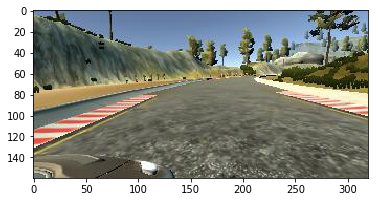

In [9]:
plt.imshow(X_train[0])
print(y_train[0])

# MODEL DEFINITION

In [10]:
def get_model(time_len=1):
    ch, row, col = 3, 160, 320  # camera format

    model = Sequential()
    
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(row, col, ch),
            output_shape=(row, col, ch)))
    
    model.add(Cropping2D(cropping=((75,25),(0,0)), input_shape=(row,col,ch)))
    
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(1024))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))

    keras.optimizers.adam(lr=0.0001)
    model.compile(optimizer="adam", loss="mse")

    return model


In [11]:
model = get_model()

history = model.fit(X_train,y_train,batch_size=128,nb_epoch=5,validation_split=0.2)

Train on 55834 samples, validate on 13959 samples
Epoch 1/5
55834/55834 [==============================] - 24s - loss: 0.0724 - val_loss: 0.0400

# Save Model

In [12]:
model.save("modelcomma_Crop_WithZero0p95_AugSides_2sig_ang0p25.h5")

if not os.path.exists("./outputs/steering_model"):
    os.makedirs("./outputs/steering_model")

model.save_weights("./outputs/steering_model/steering_angle.keras", True)
with open('./outputs/steering_model/steering_angle.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

model = get_model()
model.fit_generator(
    gen(20, args.host, port=args.port),
    samples_per_epoch=10000,
    nb_epoch=args.epoch,
    validation_data=gen(20, args.host, port=args.val_port),
    nb_val_samples=1000
)
print("Saving model weights and configuration file.")

if not os.path.exists("./outputs/steering_model"):
    os.makedirs("./outputs/steering_model")

model.save_weights("./outputs/steering_model/steering_angle.keras", True)
with open('./outputs/steering_model/steering_angle.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

# COMPILE & TRAINING

from quiver_engine import server
server.launch(model)

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

from keras.utils.visualize_util import plot
plot(model, to_file='model.png')

# TESTING